# Описание проекта. Промышленность

Для оптимизации производственных расходов, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого нужно контролировать температуру сплава. Задача — построить модель, которая будет её предсказывать, заказчик хочет использовать разработанную модель для имитации технологического процесса.

По условию заказчика, значение МАЕ у выбранной модели не должно превышать 6.8.

## Загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn.metrics
import torch
import torch.nn as nn

from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import warnings

warnings.simplefilter("ignore", UserWarning)

RANDOM_STATE = 2052023

In [2]:
db_config = {
'user': 'praktikum_student',# имя пользователя
'pwd': 'Sdf4$2;d-d30pp',# пароль
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432,# порт подключения
'db': 'data-science-final'# название базы данных,
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [3]:
engine = create_engine(connection_string) 

## Ислледование и подготовка таблиц

### Таблица data_arc

Таблица содержит данные об электродах.

Согласно документации к данным:

- `key` — номер партии;
- `BeginHeat` — время начала нагрева;
- `EndHeat` — время окончания нагрева;
- `ActivePower` — значение активной мощности;
- `ReactivePower` — значение реактивной мощности.

In [4]:
query = '''

SELECT *
FROM steel.data_arc

'''

data_arc = pd.read_sql_query(query, con=engine) 
display(data_arc)
data_arc.info()

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
0,1,11:02:14,11:06:02,0.976059,0.687084
1,1,11:07:28,11:10:33,0.805607,0.520285
2,1,11:11:44,11:14:36,0.744363,0.498805
3,1,11:18:14,11:24:19,1.659363,1.062669
4,1,11:26:09,11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,03:58:58,04:01:35,0.533670,0.354439
14872,3241,04:05:04,04:08:04,0.676604,0.523631
14873,3241,04:16:41,04:19:45,0.733899,0.475654
14874,3241,04:31:51,04:32:48,0.220694,0.145768


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14876 non-null  int64  
 1   BeginHeat      14876 non-null  object 
 2   EndHeat        14876 non-null  object 
 3   ActivePower    14876 non-null  float64
 4   ReactivePower  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


В таблице отсутствуют пропуски. Приведем время к формату datetime и найдем общее время нагрева в секундах:

In [5]:
data_arc['EndHeat'] = pd.to_datetime(data_arc['EndHeat'], format='%H:%M:%S') 
data_arc['BeginHeat'] = pd.to_datetime(data_arc['BeginHeat'], format='%H:%M:%S') 

In [6]:
data_arc['heat_time'] = (data_arc['EndHeat'] -  data_arc['BeginHeat']).dt.total_seconds()
data_arc = data_arc.drop(['BeginHeat', 'EndHeat'], axis = 1)

In [7]:
data_arc.describe()

,key,ActivePower,ReactivePower,heat_time
count,14876.000000,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592,43.894663
std,934.571502,0.408159,5.878702,3319.473237
min,1.000000,0.030002,-715.504924,-86330.000000
25%,806.000000,0.395297,0.290991,106.750000
50%,1617.000000,0.555517,0.415962,147.000000
75%,2429.000000,0.857034,0.637371,214.000000
max,3241.000000,3.731596,2.676388,907.000000


Видим некорректные значения реактивной мощности и времени нагрева, посмотрим на распределение:

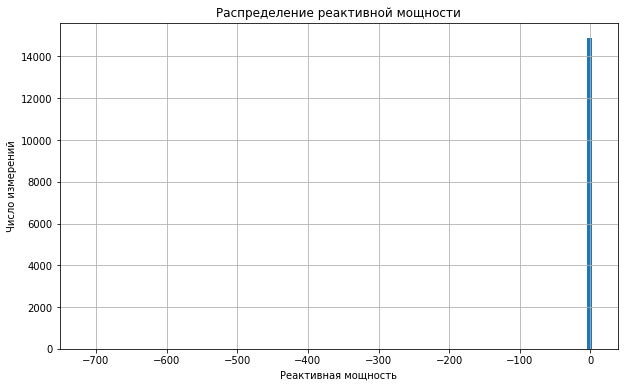

In [8]:
plt.figure(figsize=(10,6))
plt.hist(data_arc['ReactivePower'], bins=100)
plt.title('Распределение реактивной мощности')
plt.xlabel('Реактивная мощность')
plt.ylabel('Число измерений')
plt.grid(True);

Уберем отрицательные значения:

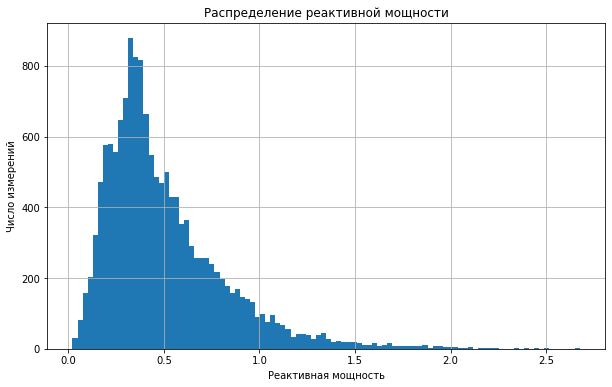

In [9]:
data_arc = data_arc.query('ReactivePower > 0')

plt.figure(figsize=(10,6))
plt.hist(data_arc['ReactivePower'], bins=100)
plt.title('Распределение реактивной мощности')
plt.xlabel('Реактивная мощность')
plt.ylabel('Число измерений')
plt.grid(True);

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Отлично)

Далее посмотрим распределение времени нагрева:

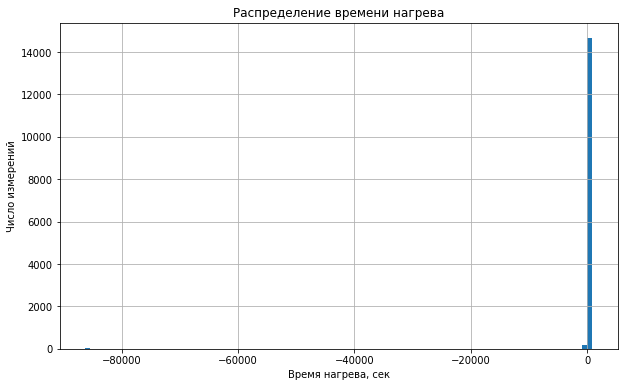

In [10]:
plt.figure(figsize=(10,6))
plt.hist(data_arc['heat_time'], bins=100)
plt.title('Распределение времени нагрева')
plt.xlabel('Время нагрева, сек')
plt.ylabel('Число измерений')
plt.grid(True);

Также есть небольшое кол-во некорректных значений, уберем их:

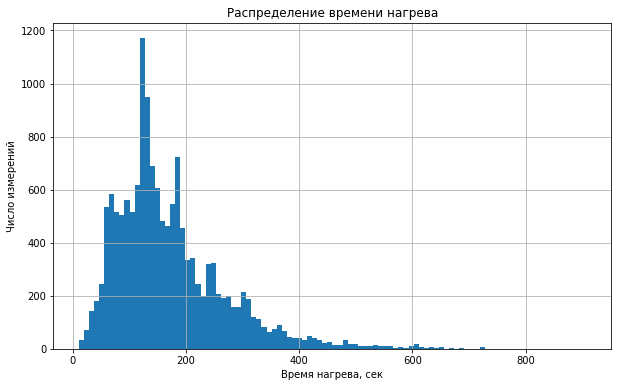

In [11]:
data_arc = data_arc.query('heat_time > 0')

plt.figure(figsize=(10,6))
plt.hist(data_arc['heat_time'], bins=100)
plt.title('Распределение времени нагрева')
plt.xlabel('Время нагрева, сек')
plt.ylabel('Число измерений')
plt.grid(True);

In [12]:
data_arc = data_arc.pivot_table(['ActivePower', 'ReactivePower', 'heat_time'], ['key'],  aggfunc='sum').reset_index()

Получили таблицу, содержащую суммарные значения активной и реактивной мощности на каждом ключе, коэффициент мощности, а также время нагрева в секундах.

### Таблицы data_bulk и data_bulk_time

Таблицы содержат данные об объёме и времени подачи сыпучих материалов.

- `key` — номер партии;
- `Bulk 1` … `Bulk 15` — объём подаваемого материала.

In [13]:
query = '''

SELECT *
FROM steel.data_bulk

'''

data_bulk = pd.read_sql_query(query, con=engine) 
display(data_bulk.head())
data_bulk.info()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [14]:
query = '''

SELECT *
FROM steel.data_bulk_time

'''

data_bulk_time = pd.read_sql_query(query, con=engine) 
display(data_bulk_time)
data_bulk_time.info()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,11:21:30,None,None,None,None,None,None,None,11:03:52,None,11:03:52,11:03:52
1,2,None,None,None,11:46:38,None,None,None,None,None,None,None,11:40:20,None,11:40:20,11:40:20
2,3,None,None,None,12:31:06,None,None,None,None,None,None,None,12:09:40,None,12:09:40,12:09:40
3,4,None,None,None,12:48:43,None,None,None,None,None,None,None,12:41:24,None,12:41:24,12:41:24
4,5,None,None,None,13:18:50,None,None,None,None,None,None,None,13:12:56,None,13:12:56,13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,None,None,22:51:28,None,None,None,None,None,None,None,None,22:46:52,None,22:46:52,22:46:52
3125,3238,None,None,23:39:11,None,None,None,None,None,None,None,None,23:33:09,None,23:33:09,23:33:09
3126,3239,None,None,None,None,None,01:51:58,None,None,None,None,None,01:39:41,None,01:33:25,01:33:25
3127,3240,None,None,None,None,None,03:12:40,None,None,None,None,None,None,None,02:41:27,02:41:27


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


Посмотрим, какую долю от общего числа составляют пропущенные значения:

In [15]:
data_bulk.isna().sum()/data_bulk.shape[0]

key        0.000000
Bulk 1     0.919463
Bulk 2     0.992969
Bulk 3     0.585171
Bulk 4     0.675935
Bulk 5     0.975391
Bulk 6     0.815916
Bulk 7     0.992010
Bulk 8     0.999680
Bulk 9     0.993928
Bulk 10    0.943752
Bulk 11    0.943432
Bulk 12    0.217002
Bulk 13    0.994247
Bulk 14    0.103228
Bulk 15    0.281560
dtype: float64

Уберем колонки, где доля пропущенных значений более 80%:

In [16]:
cols = data_bulk.columns
for col in cols:
    if data_bulk[col].isna().sum()/data_bulk.shape[0] > 0.8:
        data_bulk = data_bulk.drop(col, axis=1)
        data_bulk_time = data_bulk_time.drop(col, axis=1)

Изменим тип данных на datetime:

In [17]:
for col in data_bulk.columns.drop('key'):
    data_bulk_time[col] = pd.to_datetime(data_bulk_time[col], format='%H:%M:%S') 

Далее заменим пропуски на нули, тк пропуск обозначает, что материал не добавляли в эту партию.

In [18]:
data_bulk = data_bulk.fillna(0)
data_bulk_time = data_bulk_time.fillna(0)

### Таблица data_gas

Таблица содержит данные о продувке сплава газом.

- `key` — номер партии;
- `gas` — объём подаваемого газа.

In [20]:
query = '''

SELECT *
FROM steel.data_gas

'''

data_gas = pd.read_sql_query(query, con=engine) 
display(data_gas)
data_gas.info()

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


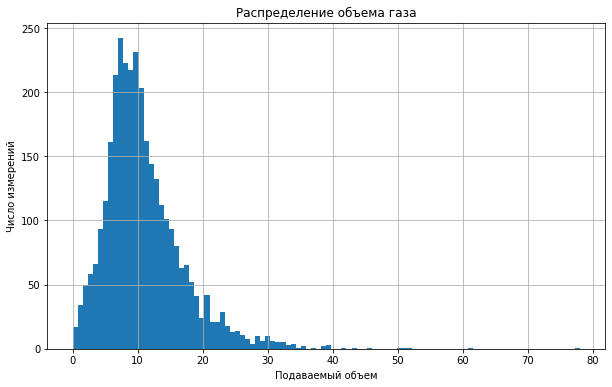

In [21]:
plt.figure(figsize=(10,6))
plt.hist(data_gas['gas'], bins=100)
plt.title('Распределение объема газа')
plt.xlabel('Подаваемый объем')
plt.ylabel('Число измерений')
plt.grid(True);

### Таблица data_temp

Таблица содержит данные об измерениях температуры.

- `key` — номер партии;
- `MesaureTime` — время замера;
- `Temperature` — значение температуры.

In [22]:
query = '''

SELECT *
FROM steel.data_temp

'''

data_temp = pd.read_sql_query(query, con=engine) 
display(data_temp)
data_temp.info()

,key,MesaureTime,Temperature
0,1,11:16:18,1571.0
1,1,11:25:53,1604.0
2,1,11:29:11,1618.0
3,1,11:30:01,1601.0
4,1,11:30:39,1613.0
...,...,...,...
15902,3241,04:03:30,1586.0
15903,3241,04:16:12,NaN
15904,3241,04:22:39,NaN
15905,3241,04:33:42,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          15907 non-null  int64  
 1   MesaureTime  15907 non-null  object 
 2   Temperature  13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [23]:
data_temp['MesaureTime'] = pd.to_datetime(data_temp['MesaureTime'], format='%H:%M:%S') 

По условию значения температуры ниже 1500 градусов — аномальные, поэтому исключим их:

In [24]:
data_temp = data_temp.query('Temperature > 1500')

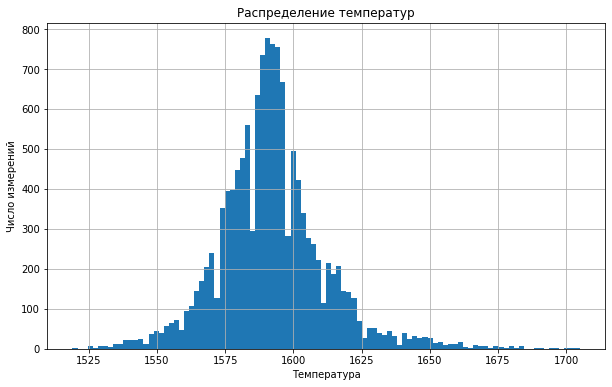

In [25]:
plt.figure(figsize=(10,6))
plt.hist(data_temp['Temperature'], bins=100)
plt.title('Распределение температур')
plt.xlabel('Температура')
plt.ylabel('Число измерений')
plt.grid(True);

In [26]:
data_temp = data_temp.reset_index(drop=True)

Оставим только ключи, у которых как минимум два наблюдения: первый и последний замеры температуры, где последний замер является целевым признаком, для этого узнаем, сколько итераций приходится на каждый ключ:

In [27]:
rm = pd.DataFrame(data_temp['key'].value_counts(ascending=True)).reset_index()
rm = rm.rename(columns={'index': 'key', 'key':'iter_num'})

In [28]:
data_temp = data_temp.merge(rm, on='key')

Удалим ключи только с 1 итерацией:

In [29]:
data_temp = data_temp.query('iter_num > 1')

По условию задачи целевой признак — последняя температура партии. Начальную температуру партии можно использовать как входной признак. Любые другие промежуточные значения температуры приведут к утечке целевого признака, их нельзя использовать как входные. Поэтому для каждого ключа оставим только первую и последнюю температуру, а также время измерения и число итераций на каждом ключе.

Первую и последнюю температуры найдем по времени для каждого ключа.

In [30]:
min_time = data_temp.groupby('key')['MesaureTime'].agg('min')
max_time = data_temp.groupby('key')['MesaureTime'].agg('max')

In [31]:
min_time = data_temp.merge(min_time, on='MesaureTime', how='inner')
max_time = data_temp.merge(max_time, on='MesaureTime', how='inner')

Соединим таблицы по ключу и найдем время измерения в секундах:

In [32]:
data_temp = min_time.merge(max_time, on='key')
data_temp['measure_time'] = (data_temp['MesaureTime_y'] - data_temp['MesaureTime_x']).dt.total_seconds()
data_temp = data_temp.drop(['MesaureTime_x', 'iter_num_x', 'MesaureTime_y'], axis=1)
data_temp = data_temp.rename(columns={'Temperature_x': 'temp_first', 'Temperature_y': 'temp_last', 'iter_num_y':'iter_num'})
data_temp

,key,temp_first,temp_last,iter_num,measure_time
0,1,1571.0,1613.0,5,861.0
1,2,1581.0,1602.0,6,1305.0
2,3,1596.0,1599.0,5,1300.0
3,4,1601.0,1625.0,3,388.0
4,786,1590.0,1597.0,5,233.0
...,...,...,...,...,...
3188,2493,1599.0,1594.0,3,1292.0
3189,2494,1585.0,1591.0,3,626.0
3190,2495,1570.0,1591.0,3,1137.0
3191,2496,1554.0,1591.0,4,1618.0


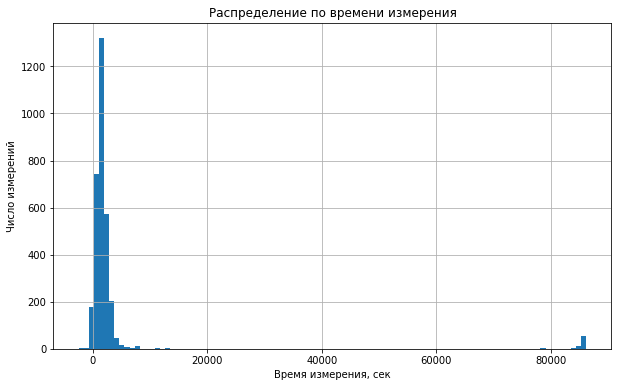

In [33]:

plt.figure(figsize=(10,6))
plt.hist(data_temp['measure_time'], bins=100)
plt.title('Распределение по времени измерения')
plt.xlabel('Время измерения, сек')
plt.ylabel('Число измерений')
plt.grid(True);

Время измерения содержит выбросы, попробуем убрать значения выше 70000, а отрицательные значения возьмем по модулю:

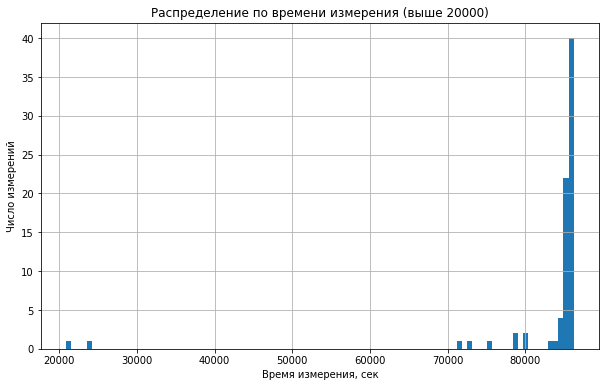

In [34]:
plt.figure(figsize=(10,6))
plt.hist(data_temp.query('measure_time > 20000')['measure_time'], bins=100)
plt.title('Распределение по времени измерения (выше 20000)')
plt.xlabel('Время измерения, сек')
plt.ylabel('Число измерений')
plt.grid(True);

In [35]:
#data_temp.loc[data_temp['measure_time'] > 80000, 'measure_time'] = data_temp['measure_time'] - 80000
data_temp.loc[data_temp['measure_time'] > 70000, 'measure_time'] = data_temp['measure_time'] - 70000
#data_temp.loc[data_temp['measure_time'] > 15000, 'measure_time'] = data_temp['measure_time'] - 15000
data_temp.loc[data_temp['measure_time'] < 0, 'measure_time'] = abs(data_temp['measure_time'])


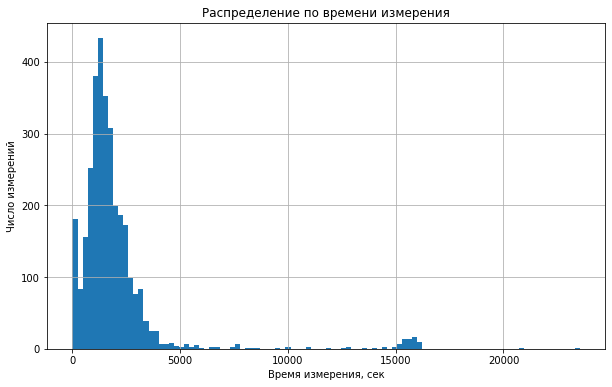

In [36]:
plt.figure(figsize=(10,6))
plt.hist(data_temp['measure_time'], bins=100)
plt.title('Распределение по времени измерения')
plt.xlabel('Время измерения, сек')
plt.ylabel('Число измерений')
plt.grid(True);

In [37]:
data_temp

,key,temp_first,temp_last,iter_num,measure_time
0,1,1571.0,1613.0,5,861.0
1,2,1581.0,1602.0,6,1305.0
2,3,1596.0,1599.0,5,1300.0
3,4,1601.0,1625.0,3,388.0
4,786,1590.0,1597.0,5,233.0
...,...,...,...,...,...
3188,2493,1599.0,1594.0,3,1292.0
3189,2494,1585.0,1591.0,3,626.0
3190,2495,1570.0,1591.0,3,1137.0
3191,2496,1554.0,1591.0,4,1618.0


Получили таблицу, содержащую в себе первое и последнее измерение температуры(целевой признак), а также время измерения в секундах и число итераций для ключа.

### Таблицы data_wire и data_wire_time

Таблицы содержит данные об объёме и времени подачи проволочных материалов.

- `key` — номер партии;
- `Wire 1` … `Wire 15` — объём подаваемых проволочных материалов.

In [38]:
query = '''

SELECT *
FROM steel.data_wire

'''

data_wire = pd.read_sql_query(query, con=engine) 
display(data_wire)
data_wire.info()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [39]:
query = '''

SELECT *
FROM steel.data_wire_time

'''

data_wire_time = pd.read_sql_query(query, con=engine) 
display(data_wire_time)
data_wire_time.info()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,11:11:41,None,None,None,None,None,None,None,None
1,2,11:46:10,None,None,None,None,None,None,None,None
2,3,12:13:47,None,None,None,None,None,None,None,None
3,4,12:48:05,None,None,None,None,None,None,None,None
4,5,13:18:15,13:32:06,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...
3076,3237,22:50:20,None,None,None,None,None,None,None,None
3077,3238,23:38:24,None,None,None,None,None,None,None,None
3078,3239,01:50:43,None,None,None,None,None,None,None,None
3079,3240,03:12:02,None,None,None,None,None,None,None,None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Посмотрим, какую долю от общего числа составляют пропущенные значения:

In [40]:
data_wire.isna().sum()/data_wire.shape[0]

key       0.000000
Wire 1    0.008439
Wire 2    0.649789
Wire 3    0.979552
Wire 4    0.995456
Wire 5    0.999675
Wire 6    0.976306
Wire 7    0.996430
Wire 8    0.993833
Wire 9    0.990587
dtype: float64

Уберем колонки, где доля пропущенных значений более 80%:

In [41]:
cols = data_wire.columns
for col in cols:
    if data_wire[col].isna().sum() / data_wire.shape[0] > 0.8:
        data_wire = data_wire.drop(col, axis=1)
        data_wire_time = data_wire_time.drop(col, axis=1)

Изменим тип данных на datetime:

In [42]:
for col in data_wire.columns.drop('key'):
    data_wire_time[col] = pd.to_datetime(data_wire_time[col], format='%H:%M:%S') 

Заменим пропуски на нули, тк пропуск обозначает, что материал не добавляли в эту партию.

In [43]:
data_wire = data_wire.fillna(0)
data_wire_time = data_wire_time.fillna(0)

### Объединение таблиц

In [44]:
df = data_arc.merge(data_gas, on='key', how='inner')
df = df.merge(data_temp, on='key', how='inner')
df = df.merge(data_bulk, on='key', how='inner')
df = df.merge(data_wire, on='key', how='inner')
df

,key,ActivePower,ReactivePower,heat_time,gas,temp_first,temp_last,iter_num,measure_time,Bulk 3,Bulk 4,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2
0,1,4.878147,3.183241,1098.0,29.749986,1571.0,1613.0,5,861.0,0.0,43.0,206.0,150.0,154.0,60.059998,0.00000
1,2,3.052598,1.998112,811.0,12.555561,1581.0,1602.0,6,1305.0,0.0,73.0,206.0,149.0,154.0,96.052315,0.00000
2,3,2.525882,1.599076,655.0,28.554793,1596.0,1599.0,5,1300.0,0.0,34.0,205.0,152.0,153.0,91.160157,0.00000
3,4,3.209250,2.060298,741.0,18.841219,1601.0,1625.0,3,388.0,0.0,81.0,207.0,153.0,154.0,89.063515,0.00000
4,5,3.347173,2.252643,869.0,5.413692,1576.0,1602.0,2,762.0,0.0,78.0,203.0,151.0,152.0,89.238236,9.11456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3001,2496,4.203064,2.810185,940.0,9.412616,1554.0,1591.0,4,1618.0,0.0,63.0,256.0,129.0,226.0,114.179527,0.00000
3002,2497,2.212379,1.851269,569.0,6.271699,1571.0,1589.0,2,717.0,0.0,85.0,230.0,124.0,226.0,94.086723,9.04800
3003,2497,2.212379,1.851269,569.0,6.271699,1571.0,1589.0,2,717.0,0.0,85.0,230.0,124.0,226.0,94.086723,9.04800
3004,2498,3.408725,2.355428,750.0,14.953657,1591.0,1594.0,5,1302.0,90.0,0.0,206.0,129.0,207.0,118.110717,0.00000


Получаем итоговую таблицу, содержащую в себе 17 столбцов.

Добавим новые столбцы, содержащие в себе полную мощность и коэффициент мощности(отношение активной мощности P к полной мощности S) по формулам:


$$
S = \sqrt{P^2 + Q^2}
$$

    
$$
λ = \frac{P}{S}
$$   

In [45]:
df['full_power'] = (df['ActivePower']**2 + df['ReactivePower']**2)**0.5 
df['power_coef'] = df['ActivePower'] / df['full_power']

## Исследовательский анализ данных

Посмотрим на взаимосвязь признаков:

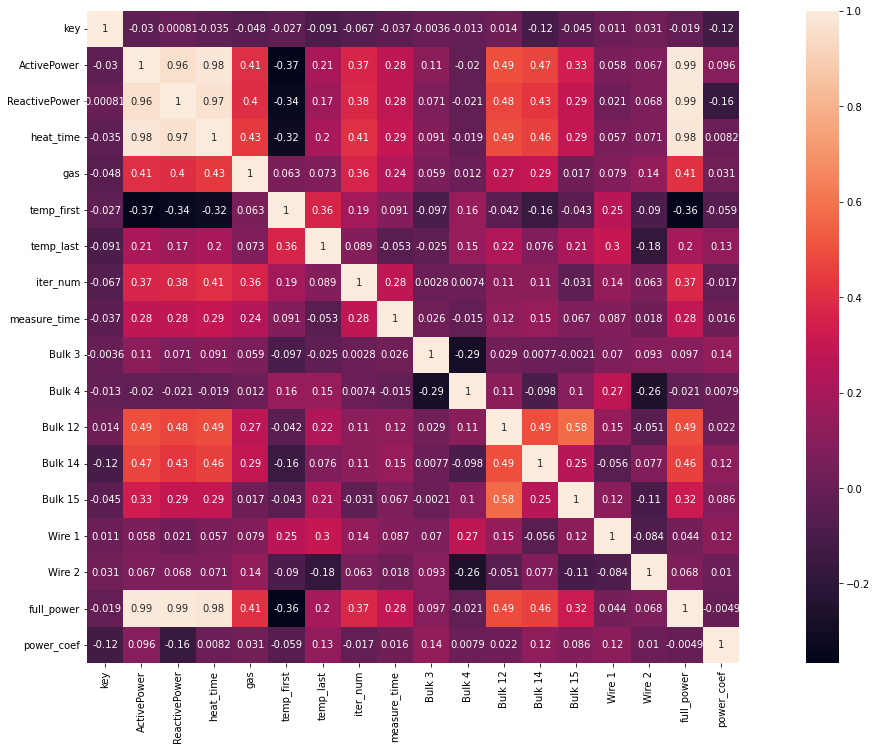

In [46]:
plt.figure(figsize=(24,12))
sns.heatmap(df.corr(),vmax=1,square=True,annot=True);

Можем увидеть мультиколлинеарность для признаков активной и реактивной мощности, а также времени нагрева и полной мощности. Удалим ключ и признаки мощностей, тк для них мы уже вычислили коэффициент:

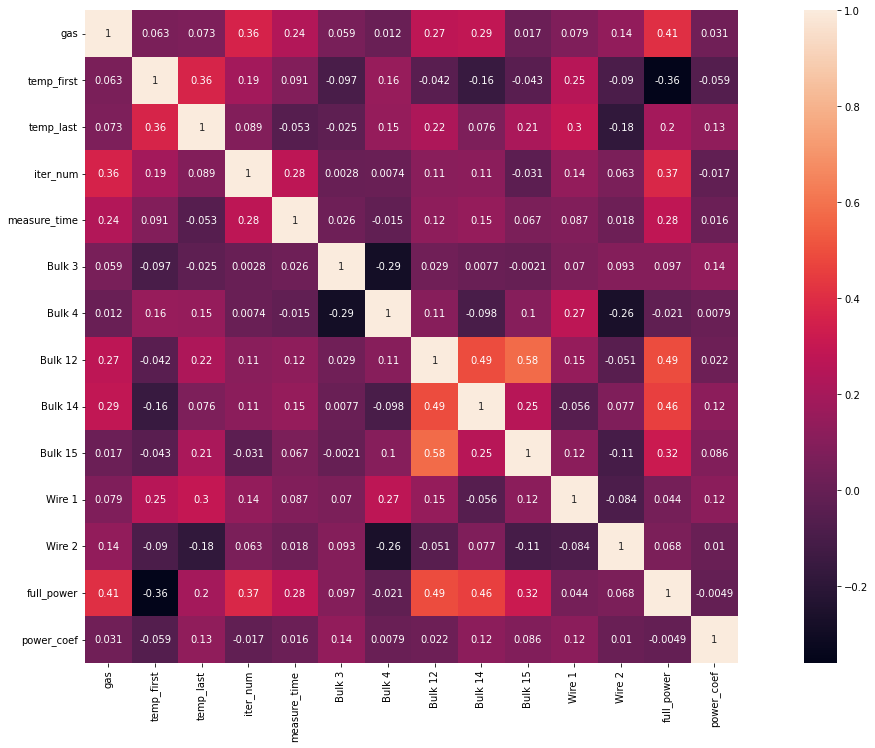

In [47]:
df = df.drop(['ReactivePower', 'ActivePower', 'key', 'heat_time'], axis=1)

plt.figure(figsize=(24,12))
sns.heatmap(df.corr(),vmax=1,square=True,annot=True);

Из тепловой карты можем увидеть, что в наибольшей степени конечная температура зависит от:
 - начальной температуры
 - полной мощности
 - объема подаваемых проволочных и сыпучих материалов
 
 
 Посмотрим на итоговое распределение признаков:

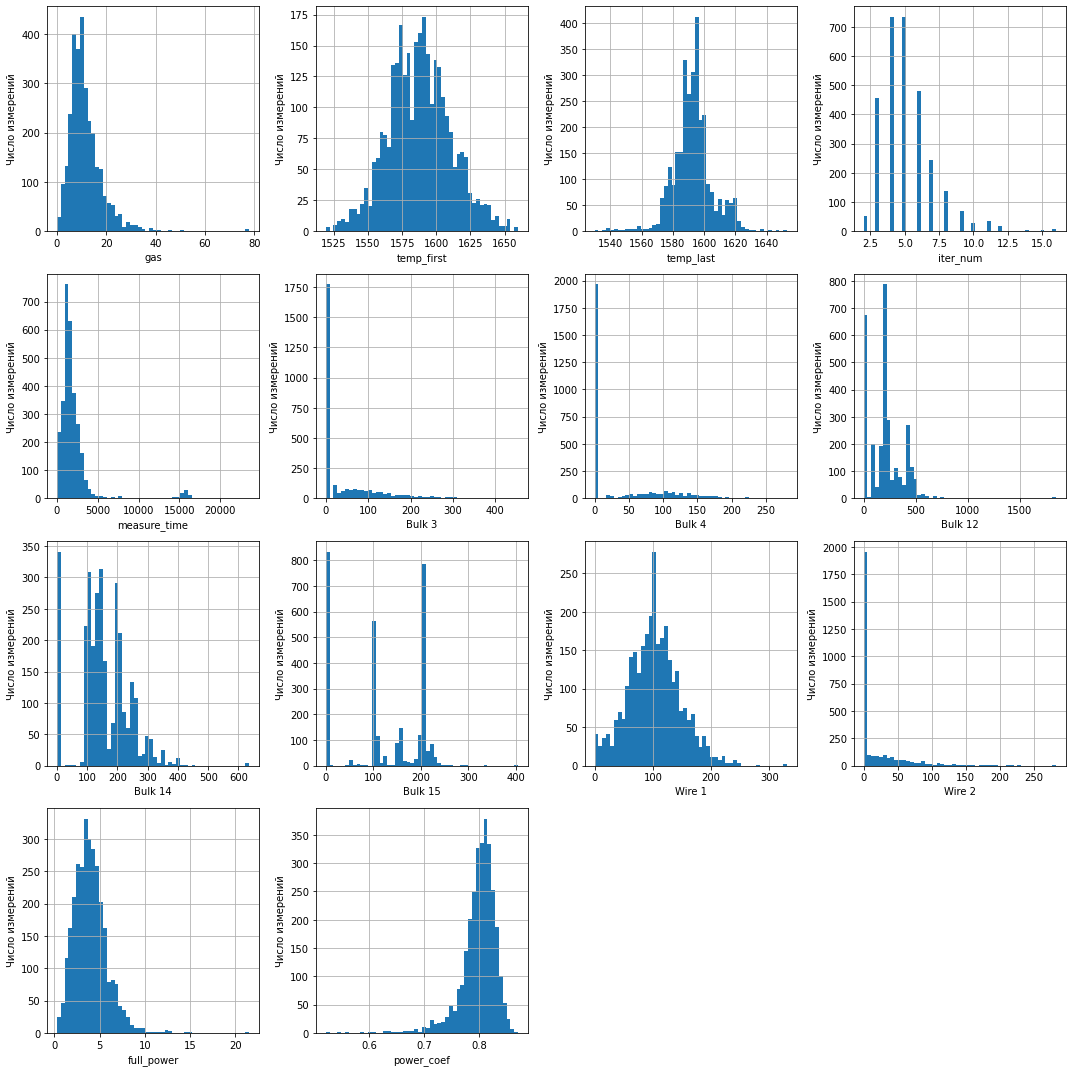

In [48]:
cols = df.columns

fig = plt.figure(figsize=(15,15))
for i in range(len(cols)):
    fig.add_subplot(4, 4, i+1)
    plt.hist(df[cols[i]], bins=50)
    plt.ylabel('Число измерений') 
    plt.xlabel(cols[i])
    plt.tight_layout()
    plt.grid(True);    

## Обучение моделей

### Разделение на выборки

In [49]:
X_train_, X_test_, y_train, y_test = train_test_split(df.drop('temp_last', axis=1), 
                                                    df['temp_last'], test_size=0.25, 
                                                    random_state=RANDOM_STATE)

Далее проведем масштабирование  данных:

In [50]:
scaler = StandardScaler()
scaler.fit(X_train_)
X_train = scaler.transform(X_train_)
X_test = scaler.transform(X_test_)

In [51]:
X_train_torch = torch.FloatTensor(X_train)
y_train_torch = torch.FloatTensor(y_train.values)#.reshape(-1, 1)
X_test_torch = torch.FloatTensor(X_test)
y_test_torch = torch.FloatTensor(y_test.values)#.reshape(-1, 1)

Объявим функцию для поиска оптимальных параметров:

In [52]:
def grid(model, params):
    grid = RandomizedSearchCV(model,
    param_distributions=params, 
    scoring='neg_mean_absolute_error', 
    n_jobs=-1, cv=5)
    grid.fit(X_train, y_train)
    best_score_mae = round(grid.best_score_*-1, 3)
    
    grid = RandomizedSearchCV(model,
    param_distributions=params, 
    scoring='r2', 
    n_jobs=-1, cv=5)
    grid.fit(X_train, y_train)
    best_score_r2 = round(grid.best_score_, 3)
    
    print('MAE на обучающей выборке:', best_score_mae)
    print('R2 на обучающей выборке:', best_score_r2)
    print('----------------------')
    print('Oптимальные параметры:\n', grid.best_params_)
    return best_score_mae, best_score_r2

### Линейная регрессия

In [53]:
params =  {}

mae_lr, r2_lr = grid(LinearRegression(), params)

MAE на обучающей выборке: 6.911
R2 на обучающей выборке: 0.373
----------------------
Oптимальные параметры:
 {}


### Дерево решений

In [54]:
params =  {'max_depth': range (1,13, 2),
           'min_samples_leaf': range (1,8),
           'min_samples_split': range (2,10,2)}

mae_dt, r2_dt = grid(DecisionTreeRegressor(random_state=RANDOM_STATE), params)

MAE на обучающей выборке: 7.377
R2 на обучающей выборке: 0.308
----------------------
Oптимальные параметры:
 {'min_samples_split': 6, 'min_samples_leaf': 5, 'max_depth': 9}


### Случайный лес

In [55]:
params =  {'n_estimators': range(10, 155, 15),
           'max_depth': range (1,15),
           'min_samples_leaf': range (1,8),
           'min_samples_split': range (2,10,2)}
           
mae_rf, r2_rf = grid(RandomForestRegressor(random_state=RANDOM_STATE), params)

MAE на обучающей выборке: 5.95
R2 на обучающей выборке: 0.495
----------------------
Oптимальные параметры:
 {'n_estimators': 25, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_depth': 11}


### CatBoost

In [56]:
params =  {'depth': range (4,10)}
           
mae_cb, r2_cb = grid(CatBoostRegressor(random_state=RANDOM_STATE, verbose=False), params)

MAE на обучающей выборке: 5.63
R2 на обучающей выборке: 0.575
----------------------
Oптимальные параметры:
 {'depth': 7}


### LightGBM

In [57]:
params =  {'max_depth': range (4,15),
          'n_estimators': range(10, 155, 15) }
           
mae_lgbm, r2_lgbm = grid(LGBMRegressor(random_state=RANDOM_STATE), params)

MAE на обучающей выборке: 5.851
R2 на обучающей выборке: 0.546
----------------------
Oптимальные параметры:
 {'n_estimators': 115, 'max_depth': 10}


### Torch

Cначала объявим класс EarlyStopping, который будет предотвращать переобучение и останавливать цикл обучения по достижению оптимального значения:

In [58]:
class EarlyStopping():
    def __init__(self, patience=7, min_delta=0):

        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss

            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
             self.counter += 1
                
             if self.counter >= self.patience:
                print('Early stopping')
                self.early_stop = True

Инициализируем нейронную сеть, состоящую из входных нейронов, двух скрытых слоев и выходного слоя:

In [59]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, num_classes):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size1)

        self.act1 = nn.Tanh()
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        
        self.fc2 = nn.Linear(hidden_size1, hidden_size2) 
        self.act2 = nn.Tanh()
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        
        
        #self.fc3 = nn.Linear(hidden_size2, num_classes) 
        self.fc3 = nn.Linear(hidden_size2, hidden_size3) 
        self.act3 = nn.Tanh()
        self.bn3 = nn.BatchNorm1d(hidden_size3)
        
        
        self.fc4 = nn.Linear(hidden_size3, num_classes) 
        
        #self.bn3 = nn.BatchNorm1d(num_classes)
        
                        
    def forward(self, x):
        out = self.fc1(x)
        out = self.act1(out)
        out = self.bn1(out)
       
        out = self.fc2(out)
        out = self.act2(out)
        out = self.bn2(out)
        #out = self.bn3(out)
        
        
        out = self.fc3(out)
        out = self.act3(out)
        out = self.bn3(out)
        
        out = self.fc4(out)

                
        return out

Обучим сеть и получим метрики:

In [60]:
n_in_neurons = X_train.shape[1]
hidden_size_1 = 150
hidden_size_2 = 75
hidden_size_3 = 25
n_out_neurons = 1                                
num_epochs = 1000  

loss = nn.MSELoss() 

batch_size = 10
dataset_train = torch.utils.data.TensorDataset(X_train_torch, y_train_torch)
dataset_test = torch.utils.data.TensorDataset(X_test_torch, y_test_torch)

train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, num_workers=0)  
net = Net(n_in_neurons, hidden_size_1, hidden_size_2, hidden_size_3, n_out_neurons)
optimizer = torch.optim.Adam(net.parameters(), lr=8e-5)

In [61]:
early_stopping = EarlyStopping() 
mae_torch = np.inf 
#mae_list = []
    
for epoch in tqdm(range(num_epochs)):
    net.train()
    for batch in train_dataloader:
        data_train, temperature_train = batch  
        optimizer.zero_grad()

        preds = net.forward(data_train).flatten()

        loss_value = torch.sqrt(loss(preds, temperature_train))
        loss_value.backward()
        optimizer.step()

    predicted_temp = [] 
    with torch.no_grad():
        net.eval()
        for batch in test_dataloader:
            data_test, temperature_test = batch
  
            test_preds = net.forward(data_test).flatten()
            predicted_temp.append(test_preds)
            RMSE_loss = torch.sqrt(loss(test_preds, temperature_test))

    predicted_temp = torch.cat(predicted_temp).detach().numpy()
    mae = mean_absolute_error(y_test_torch.detach().numpy(), predicted_temp)
    #mae_list.append(mae)
    if mae < mae_torch:
        mae_torch = mae
        best_epoch = epoch
        test_preds_best = predicted_temp
    early_stopping(mae)

    if early_stopping.early_stop:
        break 
mae_torch = round(mae_torch, 3)     
r2_torch = round(r2_score(y_test_torch.detach().numpy(), predicted_temp), 3)
print('MAE:', mae_torch, '| ep', epoch, 'from', num_epochs, '| best_epoch:', best_epoch)
print('R2:', r2_torch)


 43%|█████████████████████████████████▉                                             | 429/1000 [02:34<03:25,  2.78it/s]

Early stopping
MAE: 5.774 | ep 429 from 1000 | best_epoch: 422
R2: 0.545


### DummyRegressor

Для проверки адекватности модели сравним с константной моделью:

In [64]:
params =  {}

mae_dummy, r2_dummy = grid(DummyRegressor(strategy='mean'), params)

MAE на обучающей выборке: 8.833
R2 на обучающей выборке: -0.001
----------------------
Oптимальные параметры:
 {}


Объединим результаты в одну таблицу:

In [65]:
d={'MAE':[mae_lr, mae_dt, mae_rf, mae_cb, mae_lgbm, mae_torch, mae_dummy],
   'R2':[r2_lr, r2_dt, r2_rf, r2_cb, r2_lgbm, r2_torch, r2_dummy]}

results = pd.DataFrame(data=d, index=['LinearRegression', 
                                      'DescisionTree', 'RandomForest', 
                                      'CatBoost', 'LightGBM', 'Torch', 'DummyRegressor'])
results.sort_values(by='MAE')

,MAE,R2
CatBoost,5.630,0.575
Torch,5.774,0.545
LightGBM,5.851,0.546
RandomForest,5.950,0.495
LinearRegression,6.911,0.373
DescisionTree,7.377,0.308
DummyRegressor,8.833,-0.001


Лучший результат показывает СatBoost - 5.630 на обучающей выборке.

Выделим наиболее значимые для модели признаки:

In [67]:
smf = SelectFromModel(CatBoostRegressor(iterations=2500, depth=10, 
                                        random_state=RANDOM_STATE, verbose=False), threshold=-np.inf, max_features = 7)
smf.fit(X_train, y_train)
features_index = smf.get_support()
features = X_train_.columns[features_index]
pd.Series(features)

0             gas
1      temp_first
2    measure_time
3         Bulk 14
4          Wire 1
5      full_power
6      power_coef
dtype: object

Самым важным признаком для модели является объем газа.

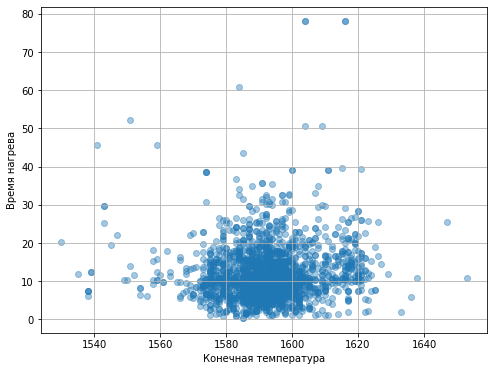

In [68]:
plt.figure(figsize=(8,6))
plt.scatter(y_train, X_train_['gas'], alpha=0.4)
plt.ylabel('Время нагрева')
plt.xlabel('Конечная температура')
plt.grid(True);

## Тестирование модели

Протестируем подель на тестовой выборке с использованием оптимальных параметров - найдем метрики МАЕ и R2:

In [66]:
model = CatBoostRegressor(iterations=2500, depth=7,random_state=RANDOM_STATE, verbose=False)
model.fit(X_train, y_train)
predicted_test = model.predict(X_test)
mae = round(mean_absolute_error(y_test, predicted_test), 3)
r2 = round(r2_score(y_test, predicted_test), 3)

print('MAE на тестовой выборке:', mae)
print('R2 на тестовой выборке:', r2)

MAE на тестовой выборке: 5.21
R2 на тестовой выборке: 0.633


## Вывод

В ходе проделанной работы были выполнены:
- загрузка и преобразование данных
- исследование признаков в таблицах 
- объединение таблиц
- обучение моделей и выбор лучшей 


Лучший результат MAE на тестовой выборке показала модель CatBoost - 5.21.
Значение R2 модели на тестовой выборке - 0.633, это достаточно далеко от единицы и говорит о том, что модель может недостаточно хорошо работать с неизвестным набором данных.

Также были выявлены признаки, наиболее влияющие на прогноз модели - 

 - газ
 - начальная температура
 - время измерения
 - объем подаваемых материалов
 - коэффициент мощности
 
Главными проблемами для проведения исследования являеются:
 - большое число выбросов и пропусков в данных, что негативно сказывается на прогнозе
 - малый объем данных - 3000 строк может быть недостаточно для точного прогноза.